# Data

Eviction Data, School Catchment Polygons, and Attendance Data
Download Landlord Tenant Cases in Philadeplhia Municipal Court from 2016 to Present: https://docs.philalegal.org/index.php/s/37j1xroW9NvX6x2
"Tenant-Addresses-Opa" is the one with geocoded addresses, dates, and docket numbers.

older: https://docs.philalegal.org/index.php/s/w9IQZrb8eDqXJkU

School Catchments (Elementary Schools)
https://hub.arcgis.com/datasets/phl::schooldist-catchments-es/about

Attendance Data
https://www.philasd.org/performance/programsservices/open-data/school-performance/#attendance

# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
#import numpy as np
!pip install "numpy<2" #to resolve an error that arose when using latest numpy
import matplotlib.pyplot as plt
import seaborn as sns


#for fuzzy matching of school names
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
!pip install python-Levenshtein 

!pip install --upgrade holoviews numpy
import hvplot.pandas

#for modeling
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np
!pip install missingno
import missingno as msno
np.random.seed(42)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


# Read in Data

In [2]:
#ensure your paths are correct if you structure the files differently
evictions_raw = pd.read_csv("./Final Project/tenant-addresses-opa.txt") #path for eviction data
catchments = gpd.read_file("./Final Project/SchoolDist_Catchments_ES.geojson") #path for catchment polygons
attendance_raw = pd.read_csv("./Final Project\SDP_95_Attendance_School_S.csv") #path for attendance data

## Change the format of the school names in the catchment to "FirstName LastName School" to match their format in the attendance data

In [3]:
#to make the name formatting match, take everything after the comma and put it at the front, then add ' School'
catchments['school_name'] = catchments['ES_NAME'].apply(
    lambda x: ' '.join(x.split(', ')[::-1]).strip() + ' School' if isinstance(x, str) and ',' in str(x) else x
)

## Map the point data of the evictions and spatially join them to school catchments

In [4]:
# Convert latitude and longitude to a geometry column (Point)
geometry = [Point(lon, lat) for lon, lat in zip(evictions_raw['longitude'], evictions_raw['latitude'])]

# Create a GeoDataFrame
evictions_gdf = gpd.GeoDataFrame(evictions_raw, geometry=geometry).set_crs("EPSG:4326", inplace=True)

In [5]:
#Spatial join evictions to school catchments
evictions_in_catchments = gpd.sjoin(
    evictions_gdf,
    catchments,
    predicate="within",
    how="left",
)
#evictions_in_catchments.head() #uncomment to view the dataframe head

,id,d_filing,parcel_number,latitude,longitude,geometry,index_right,OBJECTID,ES_ID,ES_NAME,...,GR_ID_09,GR_ID_10,GR_ID_11,GR_ID_12,ES_GRADE,MS_GRADE,HS_GRADE,Shape__Area,Shape__Length,school_name
0,LT-02-10-23-2533,2022-10-21 00:00:00,61220300,39.960056,-75.205382,POINT (-75.20538 39.96006),43.0,44.0,1470,"Locke, Alain",...,1020,1020,1020,1020,K-8,K-8,9-12,2.699519e+06,8661.940577,Alain Locke School
1,LT-16-01-04-3000,2016-01-04 00:00:00,871123700,39.918318,-75.171171,POINT (-75.17117 39.91832),9.0,10.0,2240,"Bregy, F Amedee",...,2000,2000,2000,2000,K-8,K-8,9-12,1.976860e+07,20031.922528,F Amedee Bregy School
2,LT-16-01-04-3001,2016-01-04 00:00:00,591143400,40.053903,-75.158813,POINT (-75.15881 40.0539),120.0,121.0,3426,Mastery Charter School at Pastorius,...,6060,6060,6060,6060,K-8,K-8,9-12,2.060819e+06,6615.488075,Mastery Charter School at Pastorius
3,LT-16-01-04-3002,2016-01-04 00:00:00,364306000,39.933526,-75.190118,POINT (-75.19012 39.93353),7.0,8.0,3424,Universal Institute Charter School at Alcorn,...,3417,3417,3417,3417,K-8,K-8,9-12,6.872673e+06,12326.330378,Universal Institute Charter School at Alcorn
4,LT-16-01-04-3003,2016-01-04 00:00:00,122200700,40.042783,-75.165596,POINT (-75.1656 40.04278),120.0,121.0,3426,Mastery Charter School at Pastorius,...,6060,6060,6060,6060,K-8,K-8,9-12,2.060819e+06,6615.488075,Mastery Charter School at Pastorius


## Clean up on attendance data

In [178]:
#assign each school year only one year in order to match it with a year from eviction data. I called it only the end year (ie more of the 2013-2014 academic year takes place in 2014 than 2013)
#it would have been nice to extract the full dates from the eviction data and assign them to school years directly, but I ran out of time

attendance_raw['year']=attendance_raw['School Year'].str[5:] 

#keep only rows where the attendance category is All Students 
attendance = attendance_raw[attendance_raw['Category'] == 'All Students']

#Add a new column for the previous year's attendance
#Sort by 'year' to make sure we have the data in the correct order
attendance = attendance.sort_values(by='year')
#add the new column
attendance['previous_year_attendance'] = attendance.groupby('School Name')['% with 95%+ Attendance (Yearly)'].shift(1)

#attendance.head() #uncomment to view the dataframe head

,School Year,ULCS Code,SCN Code,School Name,Sector,Category,Group,Total Students (Yearly),# with 95%+ Attendance (Yearly),% with 95%+ Attendance (Yearly),year,previous_year_attendance
0,2013-2014,1010,101,John Bartram High School,District,All Students,All Students,1250,164,13.12,2014,NaN
2054,2013-2014,6310,631,John F. McCloskey School,District,All Students,All Students,476,271,56.93,2014,NaN
2069,2013-2014,6320,632,Thomas Mifflin School,District,All Students,All Students,325,114,35.08,2014,NaN
2086,2013-2014,6340,634,Joseph Pennell School,District,All Students,All Students,459,125,27.23,2014,NaN
2100,2013-2014,6350,635,Samuel Pennypacker School,District,All Students,All Students,435,180,41.38,2014,NaN


## Matching School Names with Fuzzy Matching
Even after reformatting the names in the catchment data to FirstName LastName, there are enough differences that fuzzy matching is needed--for example, to deal with differences between, eg, "Anthony M. Marqusee School" and "Anthony Marqusee School."

I used fuzzywuzzy to accomplish this.

In [43]:
#viewing the lists of school names in the attendance data
#attendance['School Name'].unique() #uncomment and run to see how the schools are named: FirstName LastName School, for ones named after people

array(['John Bartram High School', 'West Philadelphia High School',
       'High School of the Future',
       'Paul Robeson High School for Human Services',
       'William L. Sayre High School', 'William T. Tilden School',
       'Motivation High School', 'John Barry School',
       'William C. Bryant School', 'Joseph W. Catharine School',
       'Benjamin B. Comegys School', 'Sadie Alexander School',
       'Andrew Hamilton School', 'Avery D. Harrington School',
       'Samuel B. Huey School', 'Henry C. Lea School',
       'William C. Longstreth School', 'Morton McMichael School',
       'S. Weir Mitchell School', 'Thomas G. Morton School',
       'Samuel Powel School', 'John M. Patterson School',
       'James Rhoads School', 'Martha Washington School',
       'Penrose School', 'Add B. Anderson School', 'Alain Locke School',
       'Rudolph Blankenburg School', 'Middle Years Alternative School',
       'South Philadelphia High School', 'Benjamin Franklin High School',
       'High 

In [53]:
#viewing the list of school names in the catchment/eviction data
#evictions_in_catchments['ES_NAME'].unique() #uncomment and run to see how the school names are formatted: LastName, FirstName of school namesake, for ones named after people

array(['Locke, Alain', 'Bregy, F Amedee',
       'Mastery Charter School at Pastorius',
       'Universal Institute Charter School at Alcorn', 'Willard, Frances',
       'Peirce, Thomas M', 'Hamilton, Andrew', 'Juniata Park Academy',
       'Logan, James', 'Mastery Charter School at Clymer',
       'Day, Anna Blakiston', 'Carnell, Laura H', 'Morton, Thomas G',
       'Rhoads, James', 'Mastery Charter School at Harrity',
       'Longstreth, William', 'Cassidy, Lewis C', 'Lamberton, Robert E',
       'Loesche, William H', 'Mastery Charter School at Mann',
       'Rhodes, E Washington', 'McDaniel, Delaplaine', 'Prince Hall',
       'Bryant, William Cullen', 'Edmonds, Franklin S',
       'Overbrook Elementary', 'Elkin, Lewis', 'Roosevelt, Theodore',
       'Penn Alexander', 'Kearny, General Philip', 'Moore, J Hampton',
       'Sullivan, James J', 'Henry, Charles W', 'Meade, General George G',
       'Universal Institute Charter School at Daroff',
       'Northeast Community Propel Academy'

In [9]:
# Extract unique school names from both dataframes
unique_schools_evictions = evictions_in_catchments['school_name'].unique()
unique_schools_attendance = attendance['School Name'].unique()

In [10]:
# Ensure that all input values are strings
def fuzzy_match(row, choices, scorer=fuzz.ratio, threshold=80):
    # Convert the input 'row' to string to avoid the TypeError
    row = str(row)
    
    # Extract the match and score
    match, score = process.extractOne(row, choices, scorer=scorer)
    
    # Return the match only if it meets the threshold
    return match if score >= threshold else None

In [15]:
evictions_matches= pd.DataFrame(unique_schools_evictions, columns=['school_name'])

# Apply fuzzy matching on each unique name from evictions to unique names from attendance
evictions_matches['matched_name'] = evictions_matches['school_name'].apply(
    fuzzy_match, choices=unique_schools_attendance
)

# Merge the matched names back with the original evictions_in_catchments DataFrame
evictions_in_catchments = evictions_in_catchments.merge(
    evictions_matches, on='school_name', how='left'
)

# Merge Attendance Data with Catchment Data
I added a year column for the evictions and then merged with the attendance data on both year and school name.

In [16]:
#group evictions by year
evictions_in_catchments['year'] = evictions_in_catchments['d_filing'].str[:4] #add a column with the year, extracted from the full date

In [179]:
#Add attendance data to school catchments
evictions_full = pd.merge(
    evictions_in_catchments, 
    attendance, 
    left_on=['matched_name', 'year'],  # columns in evictions, created w/ fuzzy matching
    right_on=['School Name', 'year'],  # columns in attendance
    how='inner'
)

evictions_full.head()
#len(evictions_full)

,id,d_filing,parcel_number,latitude,longitude,geometry,index_right,OBJECTID,ES_ID,ES_NAME,...,ULCS Code,SCN Code,School Name,Sector,Category,Group,Total Students (Yearly),# with 95%+ Attendance (Yearly),% with 95%+ Attendance (Yearly),previous_year_attendance
0,LT-16-01-04-3000,2016-01-04 00:00:00,871123700,39.918318,-75.171171,POINT (-75.17117 39.91832),9.0,10.0,2240,"Bregy, F Amedee",...,2240,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43
1,LT-16-01-19-4952,2016-01-19 00:00:00,262057400,39.917632,-75.177185,POINT (-75.17718 39.91763),9.0,10.0,2240,"Bregy, F Amedee",...,2240,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43
2,LT-16-01-28-6081,2016-01-28 00:00:00,881113407,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,2240,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43
3,LT-16-01-28-6084,2016-01-28 00:00:00,881113401,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,2240,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43
4,LT-16-01-28-6088,2016-01-28 00:00:00,881113408,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,2240,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43


In [180]:
evictions_by_year = evictions_full.groupby(['year', 'school_name']).size().reset_index(name='eviction_count') #group by year and elementary school catchment, then count and make that a df
evictions_by_year.head()

,year,school_name,eviction_count
0,2016,Abram Jenks School,14
1,2016,Add B Anderson School,76
2,2016,Alain Locke School,143
3,2016,Albert M Greenfield School,234
4,2016,Alexander Adaire School,42


In [181]:
#merge those counts into the main df

evictions_and_attendance = pd.merge(evictions_full, evictions_by_year, on=['year', 'school_name'], how='inner')

# now this df has both eviction count and attendance data
evictions_and_attendance.head()

,id,d_filing,parcel_number,latitude,longitude,geometry,index_right,OBJECTID,ES_ID,ES_NAME,...,SCN Code,School Name,Sector,Category,Group,Total Students (Yearly),# with 95%+ Attendance (Yearly),% with 95%+ Attendance (Yearly),previous_year_attendance,eviction_count
0,LT-16-01-04-3000,2016-01-04 00:00:00,871123700,39.918318,-75.171171,POINT (-75.17117 39.91832),9.0,10.0,2240,"Bregy, F Amedee",...,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43,58
1,LT-16-01-19-4952,2016-01-19 00:00:00,262057400,39.917632,-75.177185,POINT (-75.17718 39.91763),9.0,10.0,2240,"Bregy, F Amedee",...,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43,58
2,LT-16-01-28-6081,2016-01-28 00:00:00,881113407,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43,58
3,LT-16-01-28-6084,2016-01-28 00:00:00,881113401,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43,58
4,LT-16-01-28-6088,2016-01-28 00:00:00,881113408,39.903321,-75.192340,POINT (-75.19234 39.90332),9.0,10.0,2240,"Bregy, F Amedee",...,224,F. Amedee Bregy School,District,All Students,All Students,470,123,26.17,27.43,58


# Group by Year and School
This gave me a summary of how many evictions there were in each school catchment each year, which I then plotted to examine for visual trends.

In [338]:
evictions_grouped_for_plotting = evictions_and_attendance.sort_values('d_filing').drop_duplicates(['School Name','year'], keep='last').reset_index()

# Evictions Over Time

Because there are 100+ schools, it made more sense to plot the average than to try to plot all of them. We can see the 2020 drop in evictions caused by the eviction moratorium due to Covid-19.

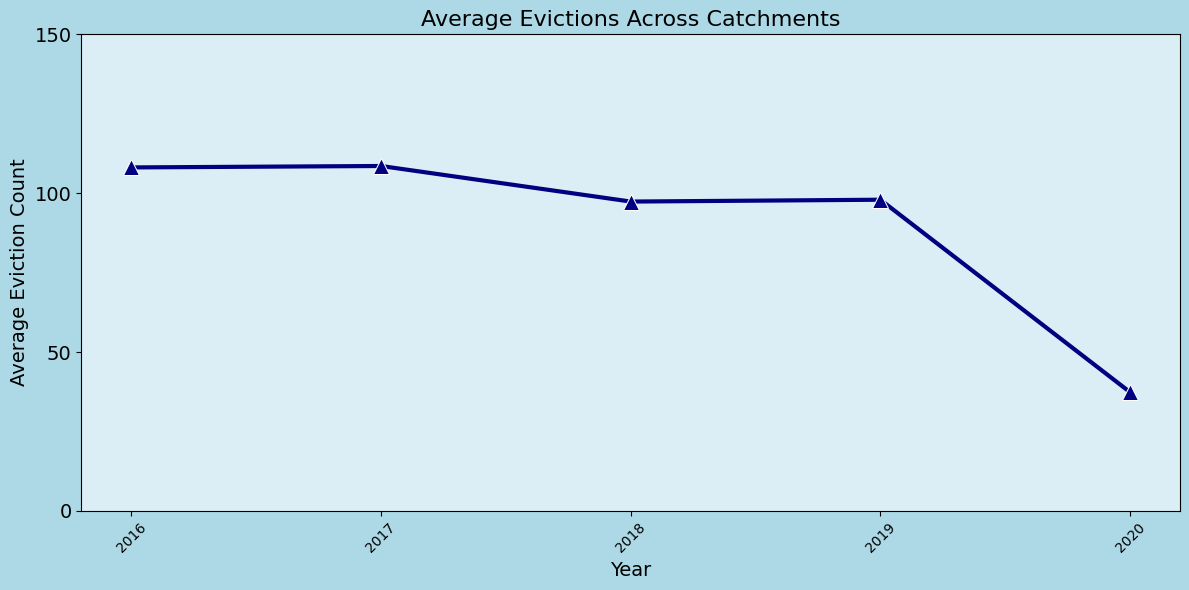

In [420]:
# Group by 'year' and calculate the average eviction count
avg_evictions_over_time = evictions_grouped_for_plotting.groupby('year')['eviction_count'].mean().reset_index()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the average eviction count over time (on the left y-axis)
sns.lineplot(data=avg_evictions_over_time, x='year', y='eviction_count', marker='^', markersize=12, markerfacecolor='#000080', ax=ax1, color='#000080', linewidth=3)

ax1.set_facecolor('#dbeef6')
fig.patch.set_facecolor('lightblue')

# Set title and labels
plt.title('Average Evictions Across Catchments', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Average Eviction Count', fontsize=14)
ax1.tick_params(axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Manually set the y-ticks
y_ticks = np.arange(0, avg_evictions_over_time['eviction_count'].max() + 50, 50)
plt.yticks(y_ticks, fontsize=14)

# Adjust the layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

# Attendance Rates Over Time
In general, average 95%+ attendance rates hovered around 40% before increasing slightly from 2017-2020.

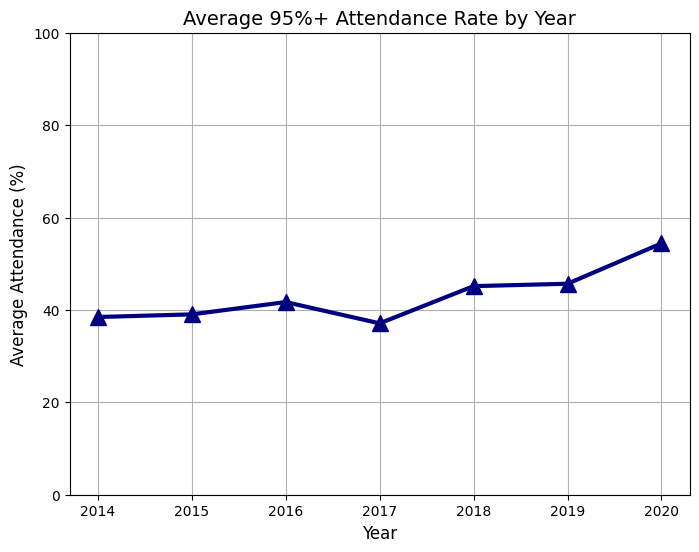

In [428]:
attendance['% with 95%+ Attendance (Yearly)'] = pd.to_numeric(attendance['% with 95%+ Attendance (Yearly)'], errors='coerce')

#  Group by year and calculate average attendance
avg_attendance_by_year = attendance.groupby('year')['% with 95%+ Attendance (Yearly)'].mean()

# Plot the average attendance by year
plt.figure(figsize=(8, 6))
plt.plot(avg_attendance_by_year.index, avg_attendance_by_year.values, marker='^', markersize=12, linestyle='-', color='#000080', linewidth=3)

# Adding title and labels
plt.title('Average 95%+ Attendance Rate by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Attendance (%)', fontsize=12)
plt.ylim(0, 100)

# Show the plot
plt.grid(True)
plt.show()


# Attendance Rate vs Eviction Count
Combined across all years, average attendance rates dropped when there were more evictions at first, but the pattern did not hold for the catchments with the highest numbers of evictions

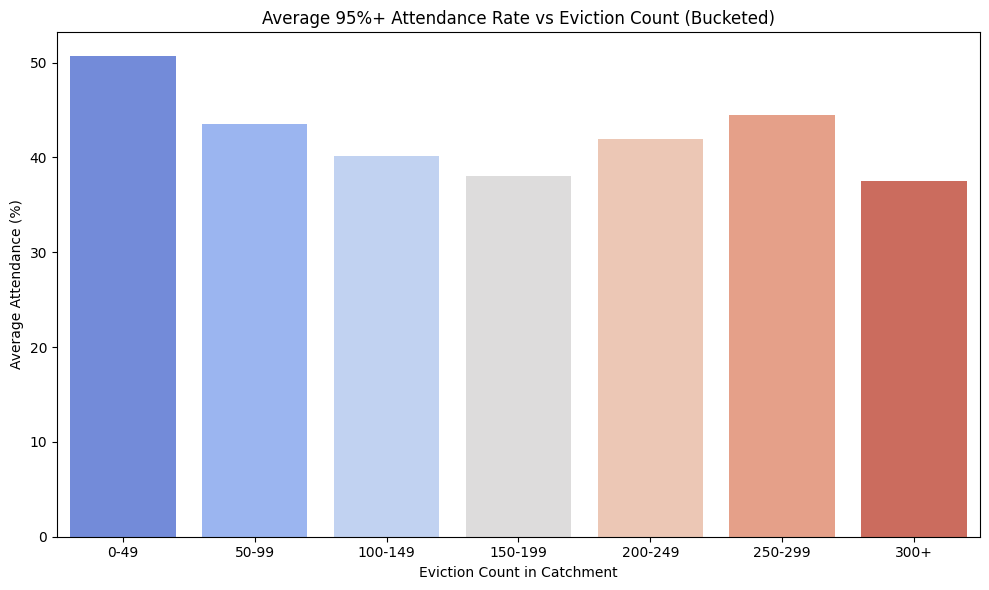

In [396]:
# Create eviction buckets 
bins = [0, 50, 100, 150, 200, 250, 300, 1000]  # Example bins (customize as needed)
labels = ['0-49', '50-99', '100-149', '150-199', '200-249', '250-299', '300+']  # Labels for the bins
evictions_grouped_for_plotting['eviction_bucket'] = pd.cut(
    evictions_grouped_for_plotting['eviction_count'], bins=bins, labels=labels, right=False)

# Calculate the average attendance per eviction bucket
attendance_by_bucket = evictions_grouped_for_plotting.groupby('eviction_bucket')['% with 95%+ Attendance (Yearly)'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='eviction_bucket', y='% with 95%+ Attendance (Yearly)', data=attendance_by_bucket, palette='coolwarm')

# Set plot labels and title
plt.xlabel('Eviction Count in Catchment')
plt.ylabel('Average Attendance (%)')
plt.title('Average 95%+ Attendance Rate vs Eviction Count (Bucketed)')

# Show the plot
plt.tight_layout()
plt.show()

# Examining the Data Year by Year
Plotting the school attendance rates by evictions in catchment separately for each year in the data (2016-2020), 
I could see the expected pattern of a negative slope: more evictions negatively impacts attendance. 
Because eviction numbers could be quite different for the city overall year-to-year, it was easier to see patterns within years
than in the data across all years.

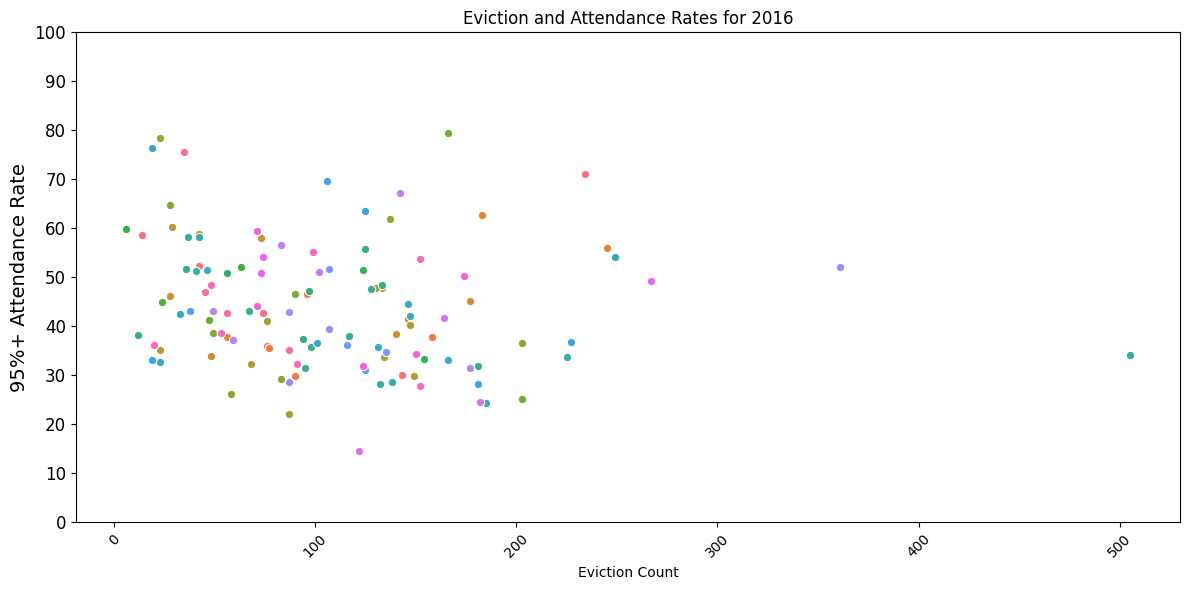

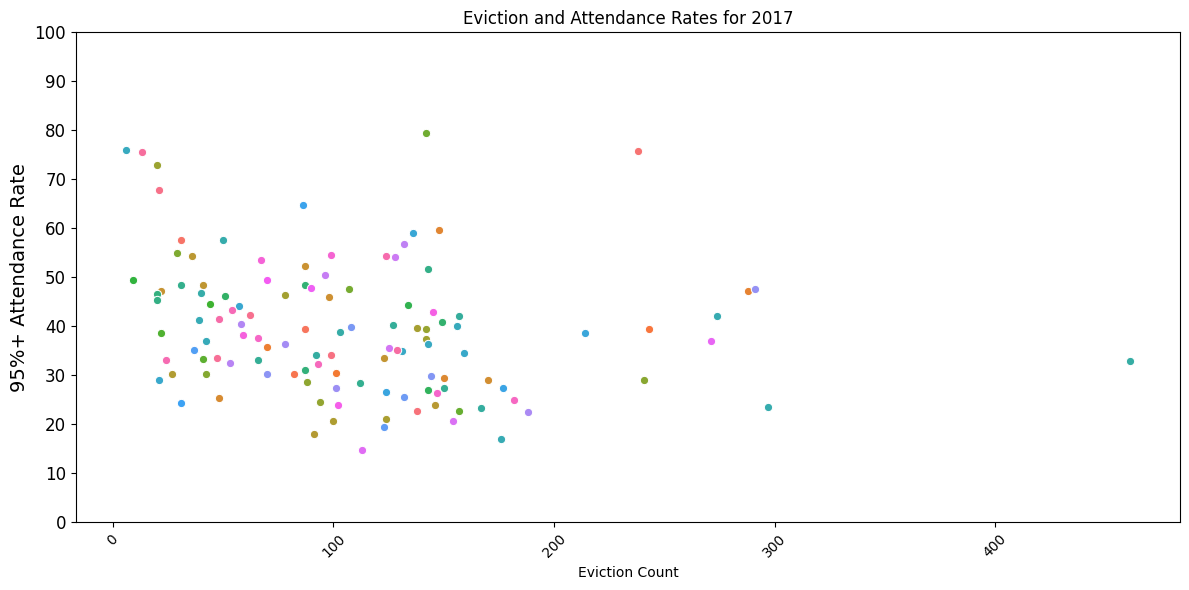

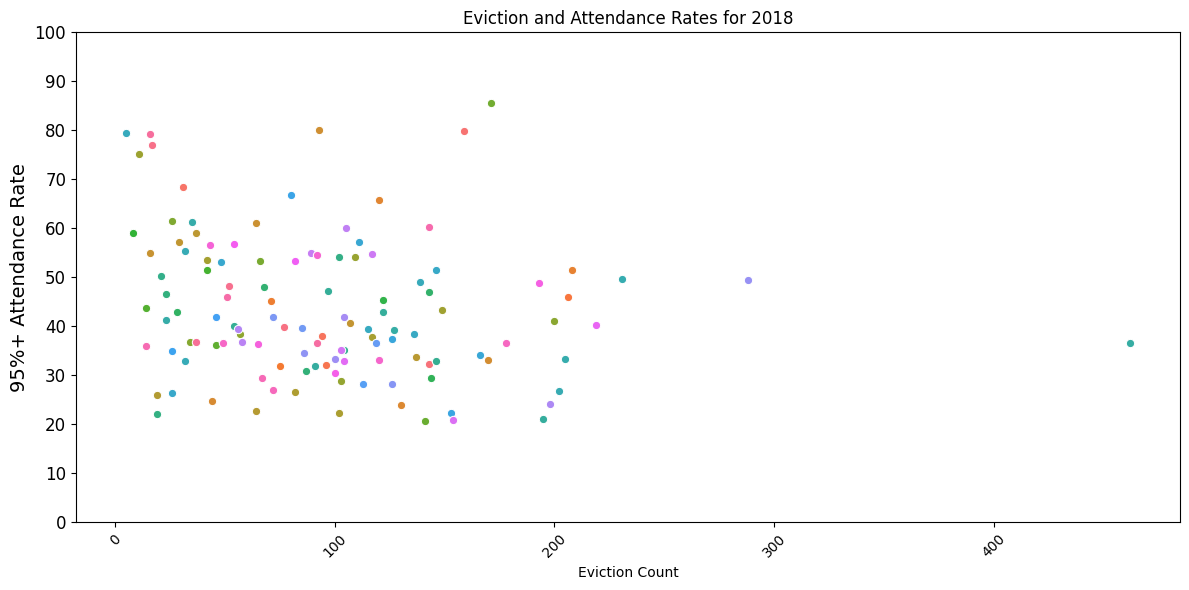

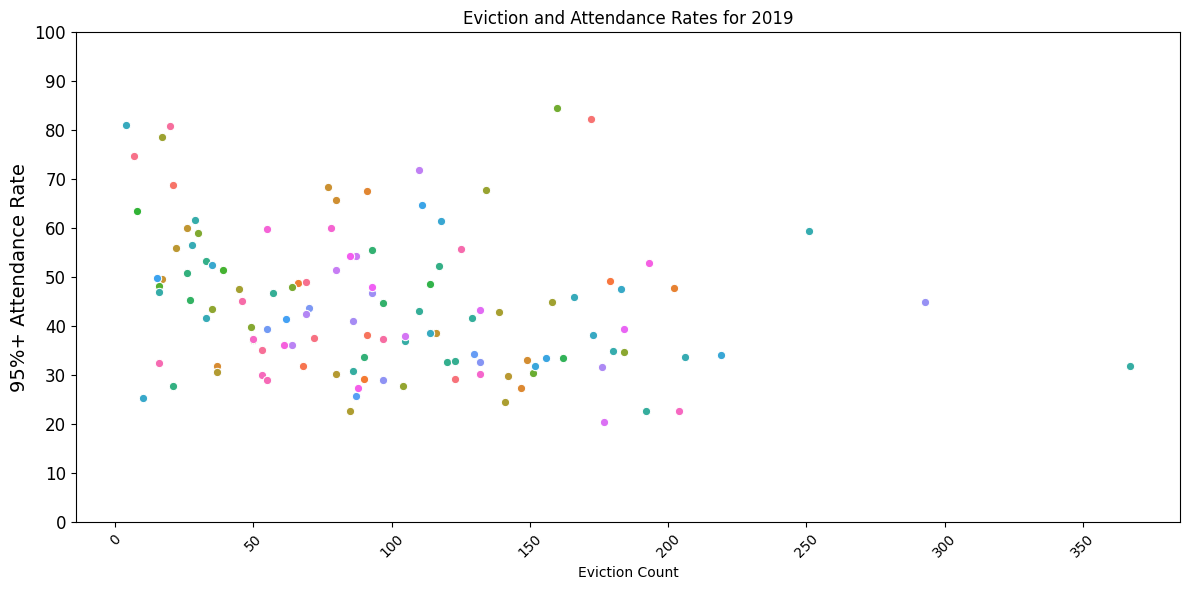

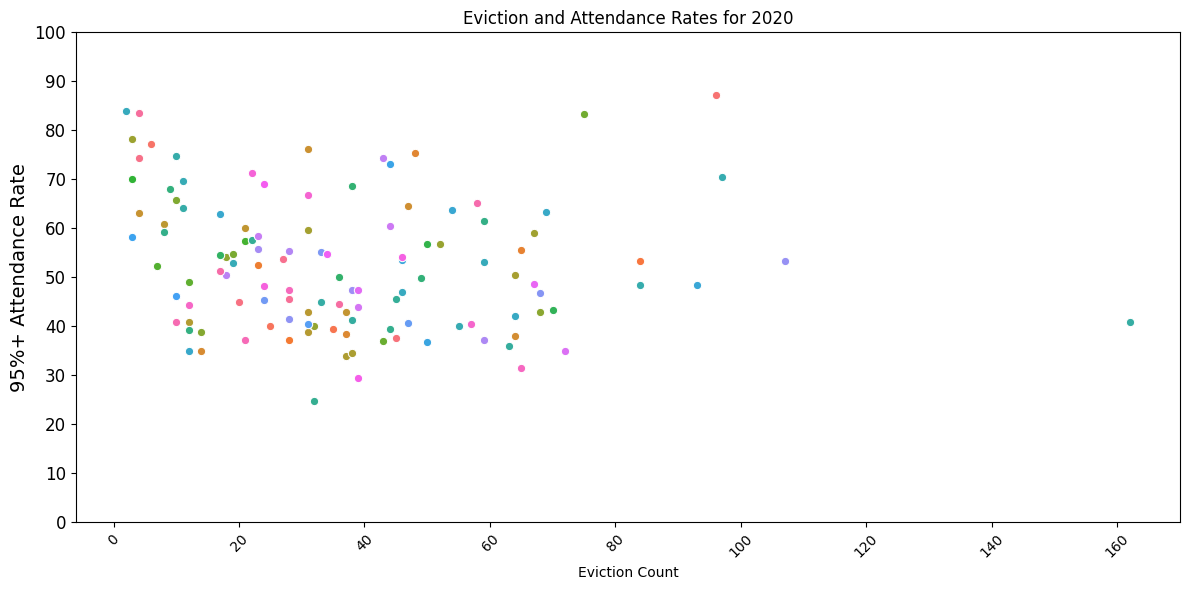

In [430]:
years = evictions_grouped_for_plotting['year'].unique()  # Get all unique years

# Iterate through each year to create a plot for that year
for year in years:
    # Filter the data for the current year
    data_for_year = evictions_grouped_for_plotting[evictions_grouped_for_plotting['year'] == year]
    
    # Create a figure and axis
    fig4, ax4 = plt.subplots(figsize=(12, 6))

    # Plot eviction count (on the left y-axis)
    sns.lineplot(data=data_for_year, x='eviction_count', y='% with 95%+ Attendance (Yearly)', hue='school_name', marker='o', ax=ax4, legend=None, color='b')

    # Set labels and title for the first axis (Evictions)
    ax4.set_xlabel('Eviction Count')
    ax4.set_ylabel('95%+ Attendance Rate', size=14)

    # Set the title for the year
    ax4.set_title(f"Eviction and Attendance Rates for {year}")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Manually set the y-ticks
    y_ticks4 = np.arange(0, 101, 10)  # Set the ticks from 0 to 100 with a step of 10
    plt.yticks(y_ticks4, fontsize=12)

    # Adjust the layout to avoid clipping
    plt.tight_layout()

    # Show the plot for the current year
    plt.show()


## What about Prior Year Evictions?
I was curious if evictions from the year previous would correlate more or less with poor attendance; 
these graphs showed a lower correlation than looking at evictions in the same year.

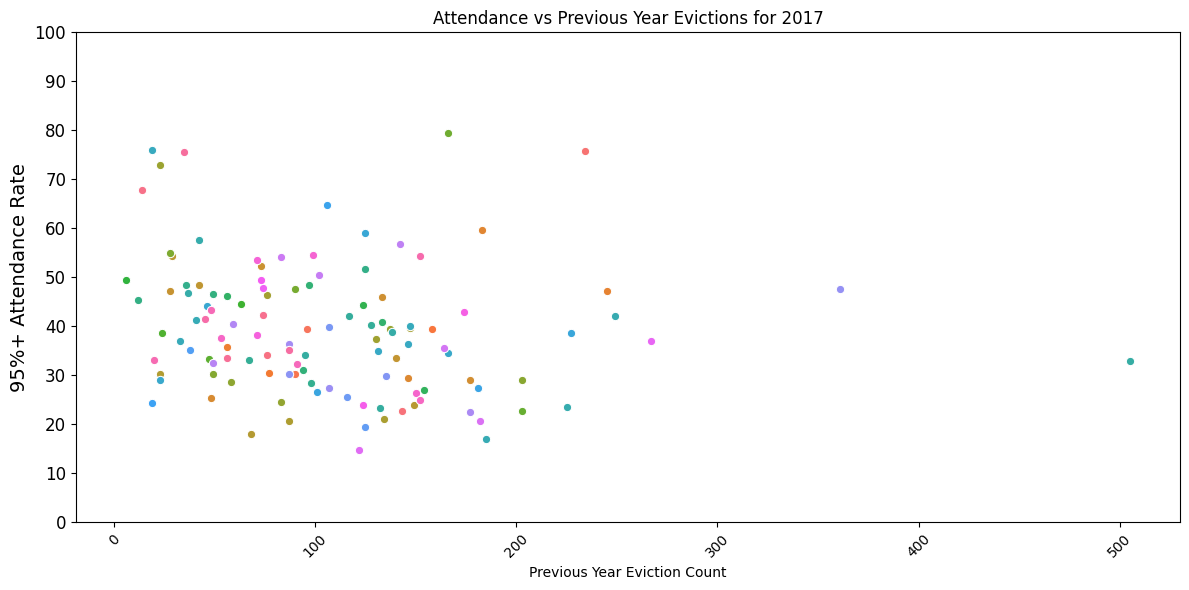

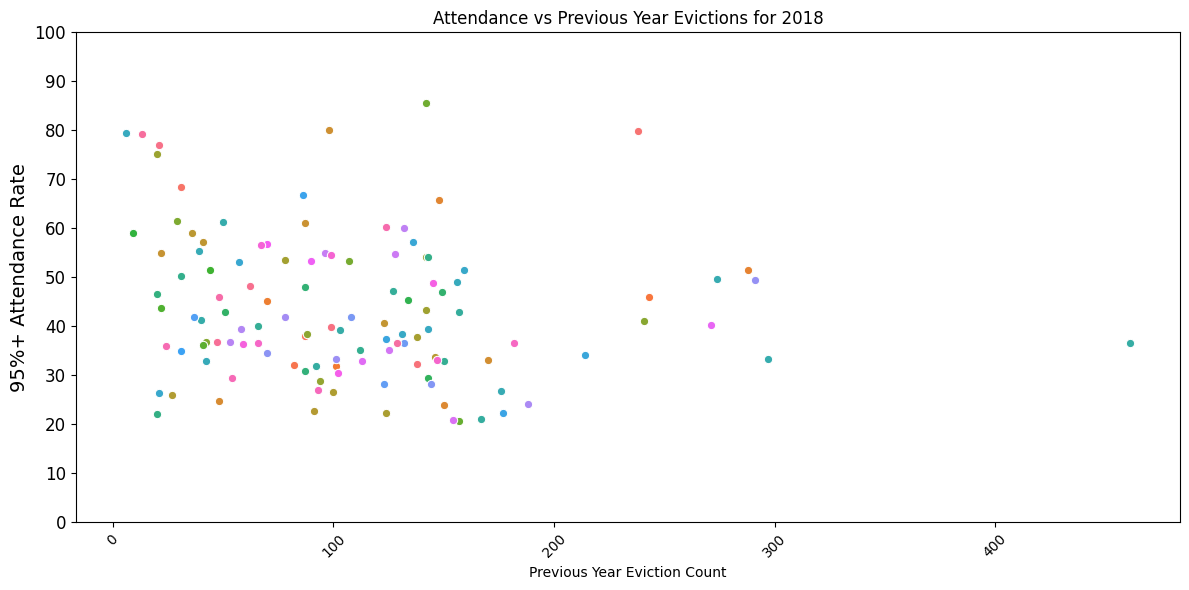

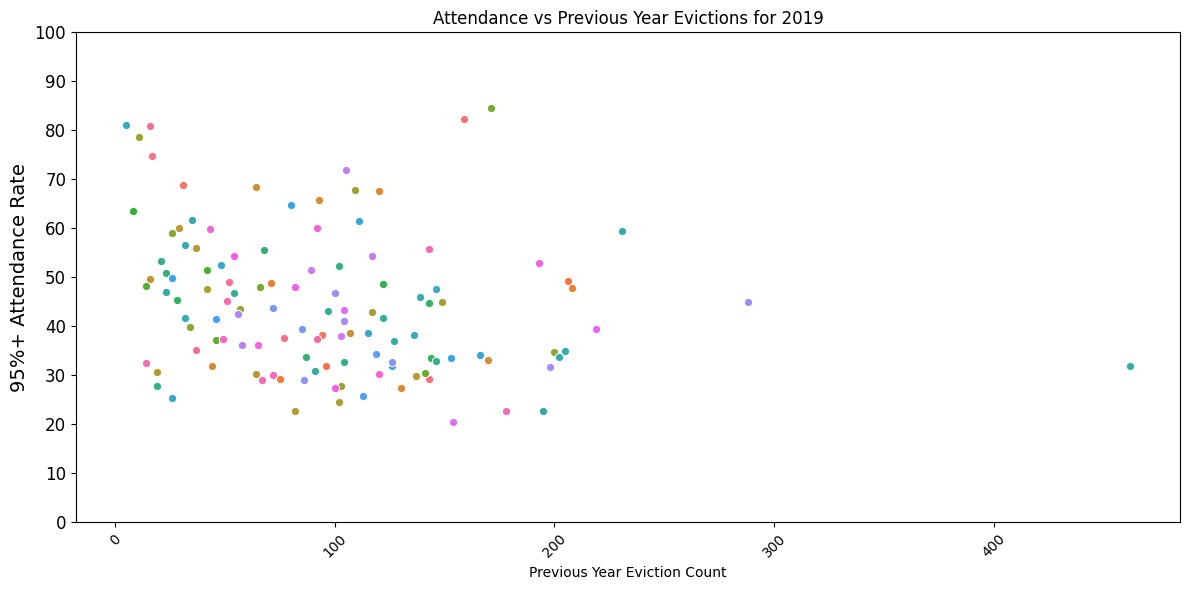

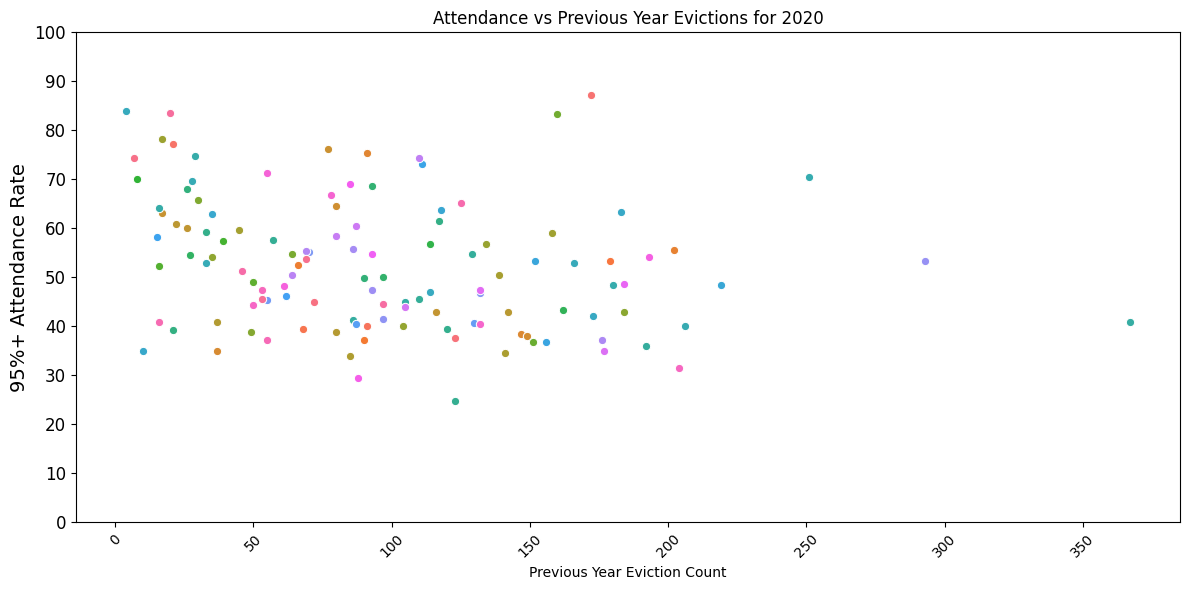

In [431]:
# sort the dataset by year
evictions_grouped_for_plotting = evictions_grouped_for_plotting.sort_values(by=['school_name', 'year'])

# Create a new column for the previous year's eviction count
evictions_grouped_for_plotting['previous_year_eviction_count'] = evictions_grouped_for_plotting.groupby('school_name')['eviction_count'].shift(1)

# Drop rows where there is no previous year's eviction data (i.e., the first year for each school)
evictions_grouped_for_plotting_prev = evictions_grouped_for_plotting.dropna(subset=['previous_year_eviction_count'])

# Iterate through each year to create a plot for that year
for year in evictions_grouped_for_plotting_prev['year'].unique():
    # Filter the data for the current year
    data_for_year = evictions_grouped_for_plotting_prev[evictions_grouped_for_plotting_prev['year'] == year]
    
    # Create a figure and axis
    fig5, ax5 = plt.subplots(figsize=(12, 6))

    # Plot the attendance rate against the previous year's eviction count
    sns.lineplot(data=data_for_year, x='previous_year_eviction_count', y='% with 95%+ Attendance (Yearly)', 
                 hue='school_name', marker='o', ax=ax5, legend=None, color='b')

    # Set labels and title for the first axis (Evictions)
    ax5.set_xlabel('Previous Year Eviction Count')
    ax5.set_ylabel('95%+ Attendance Rate', size=14)

    # Set the title for the year
    ax5.set_title(f"Attendance vs Previous Year Evictions for {year}")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Manually set the y-ticks
    y_ticks5 = np.arange(0, 101, 10)  # Set the ticks from 0 to 100 with a step of 10
    plt.yticks(y_ticks5, fontsize=12)

    # Adjust the layout to avoid clipping
    plt.tight_layout()

    # Show the plot for the current year
    plt.show()


# Machine Learning: Modeling with Scikit

In [219]:
model = LinearRegression()

LinearRegression()

In [231]:
# split into training and testing data
train_set, test_set = train_test_split(evictions_grouped_for_plotting, test_size=0.3, random_state=42)

# Features
I wanted to see if I could predict attendance rate using the following information:
    1. Eviction count in the catchment
    2. Year
    3. Attendance rate from the previous year
    4. Eviction count from the previous year

In [232]:
# Features
X_train = train_set[['eviction_count', 'year', 'previous_year_attendance', 'previous_year_eviction_count']].values

X_test = test_set[['eviction_count', 'year', 'previous_year_attendance', 'previous_year_eviction_count']].values

# The output to predict
y_train = train_set['% with 95%+ Attendance (Yearly)'].values
y_test = test_set['% with 95%+ Attendance (Yearly)'].values

In [222]:
scaler = StandardScaler()

In [233]:
# Scale the training features
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test features using the same scaling parameters from the training data
X_test_scaled = scaler.transform(X_test)

## Fit and score the model
Result: on the training data, the model scores 0.856. On the test data, it scores 0.838.

In [224]:
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train)

0.8563331029398836

In [258]:
y_pred = model.predict(X_test_scaled)
model.score(X_test_scaled, y_test)

0.8375502733651176

# Plot the Predicted vs Actual Results

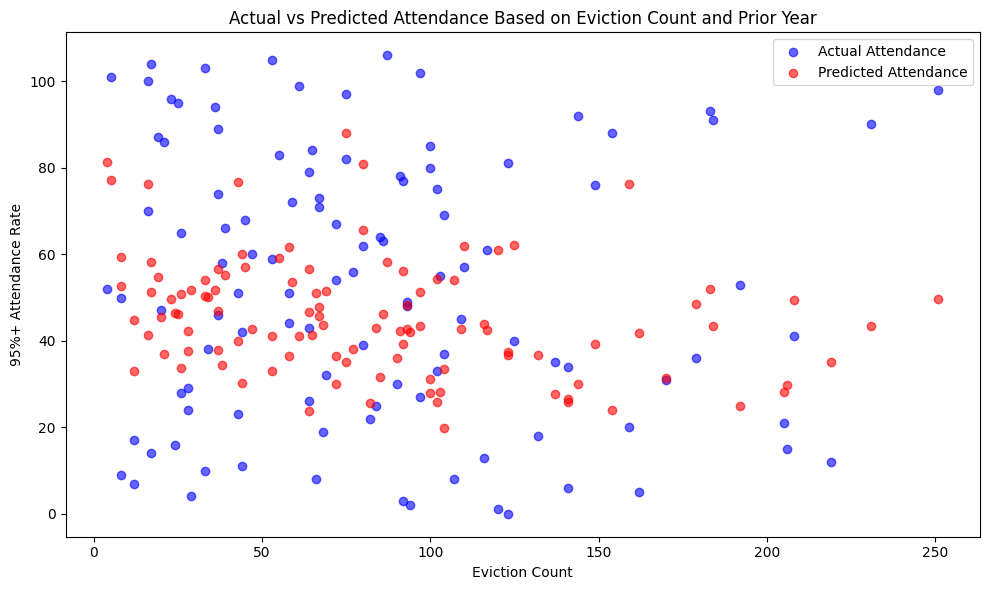

In [457]:

plt.figure(figsize=(10, 6))


# eviction count, the first index (0)
plt.scatter(X_test[:, 0], y_test, color='blue', label='Actual Attendance', alpha=0.6)

# Overlay the predicted values on the same graph
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted Attendance', alpha=0.6)

# Manually set the y-ticks
y_ticks = np.arange(0, 101, 10)  # Set the ticks from 0 to 100 with a step of 10
plt.yticks(y_ticks, fontsize=12)
plt.gca().get_yaxis().clear()

# Set labels and title
plt.xlabel('Eviction Count')
plt.ylabel('95%+ Attendance Rate')
plt.title('Actual vs Predicted Attendance Based on Eviction Count and Prior Year')

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

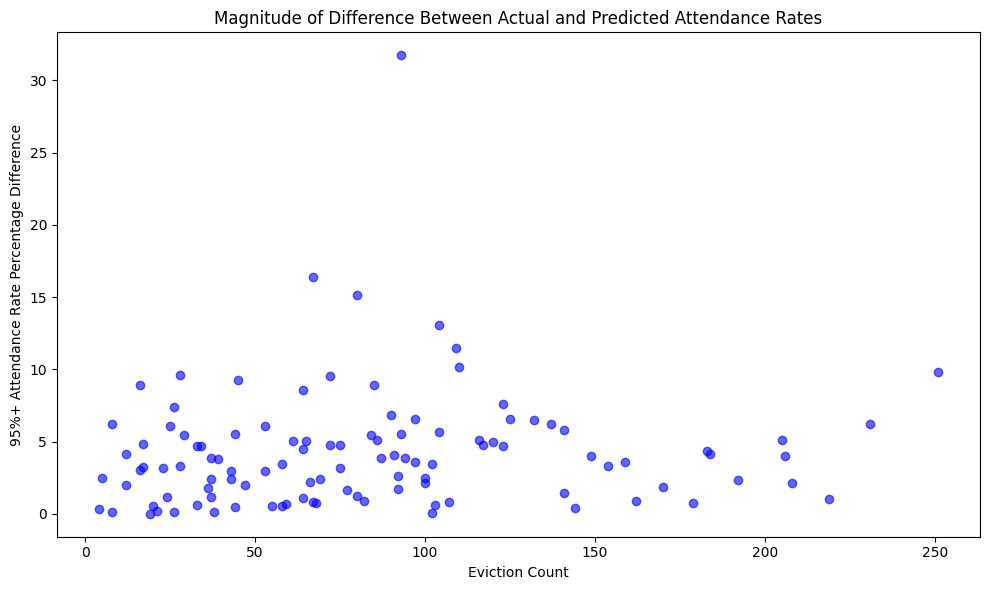

In [442]:
plt.figure(figsize=(10, 6))

# Coerce the arrays to numeric values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred, errors='coerce')

# Subtract one array from the other
y_dif = abs(y_pred_numeric - y_test_numeric)

# eviction count, the first index (0)
plt.scatter(X_test[:, 0], y_dif, color='blue', label='Actual Attendance', alpha=0.6)

# Set labels and title
plt.xlabel('Eviction Count')
plt.ylabel('95%+ Attendance Rate Percentage Difference')
plt.title('Magnitude of Difference Between Actual and Predicted Attendance Rates')

# Show the plot
plt.tight_layout()
plt.show()


# A Subgroup: 2018
I was curious to see how the same process would fair examining only a single year, since I noted that the patterns might be stronger within a year
compared to between years.
Following the same process as above but filtering only to 2018 data, the results were:

-Score on training data: 0.798

-Score on test data: 0.884

It does seem odd that the model would be better on the test data than on the training data; but, at this point, within a single year, we may be
getting into small sample sizes.

In [300]:
df_2018 = evictions_grouped_for_plotting[evictions_grouped_for_plotting['year'] == '2018']

In [301]:
X_2018 = df_2018[['eviction_count', 'year', 'previous_year_attendance', 'previous_year_eviction_count']]  # Feature (independent variable)
y_2018 = df_2018['% with 95%+ Attendance (Yearly)']  # Target (dependent variable)

In [302]:
X_train18, X_test18, y_train18, y_test18 = train_test_split(X_2018, y_2018, test_size=0.2, random_state=42)

In [303]:
scaler = StandardScaler()
# Scale the training features
X_train_scaled18 = scaler.fit_transform(X_train18)

# Scale the test features using the same scaling parameters from the training data
X_test_scaled18 = scaler.transform(X_test18)


In [309]:
# Initialize the model 
model18 = LinearRegression()

# Fit the model on the training data
model18.fit(X_train_scaled18, y_train18)

# Make predictions
y_pred18 = model18.predict(X_test_scaled18)

# Evaluate the model
mse = mean_squared_error(y_test18, y_pred18)
print(f'Mean Squared Error: {mse}')

# Print the model's coefficients 
print(f'Model Coefficients: {model.coef_}')

Mean Squared Error: 23.312277965349583
Model Coefficients: [-2.69921033  0.95368761 12.84878094  1.68647672]


In [310]:
model18.score(X_train_scaled18, y_train18)

0.7978618516361651

In [312]:
model18.score(X_test_scaled18, y_test18)

0.8836601358171393

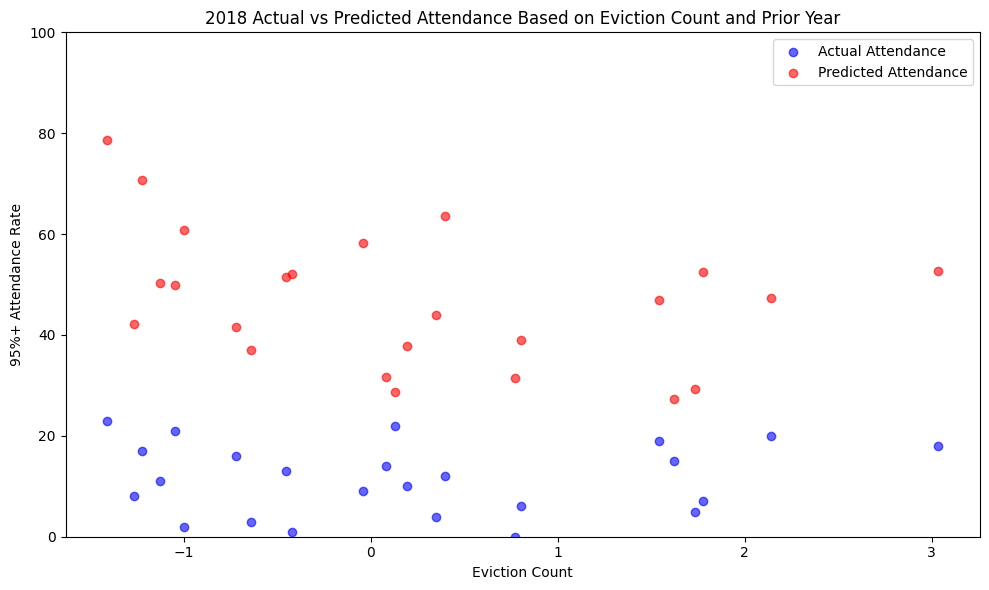

In [458]:
plt.figure(figsize=(10, 6))

# eviction count, the first index (0)
plt.scatter(X_test_scaled18[:, 0], y_test18, color='blue', label='Actual Attendance', alpha=0.6)

# Overlay the predicted values on the same graph
plt.scatter(X_test_scaled18[:, 0], y_pred18, color='red', label='Predicted Attendance', alpha=0.6)

# Manually set the y-ticks
y_ticks = np.arange(0, 101, 10)  # Set the ticks from 0 to 100 with a step of 10
plt.yticks(y_ticks, fontsize=12)
plt.gca().get_yaxis().clear()

# Set labels and title
plt.xlabel('Eviction Count')
plt.ylabel('95%+ Attendance Rate')
plt.title('2018 Actual vs Predicted Attendance Based on Eviction Count and Prior Year')

# Set y-axis range from 0 to 100
plt.ylim(0, 100)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# What do evictions add to the model?
My model scored well for predicting attendance using previous year attendance, year, eviction count, and previous year eviction count. But how 
much did eviction information contribute? To find out, I ran the same linear modeling process with only the year and previous year attendance data, no eviction data.
    
Results: without eviction data, the model scored 0.849 on the training data and 0.827 on the test data.

Comparing to the results with eviction information, this means that adding eviction information improved by model's score by 0.01.

In [273]:
train_set_noevic, test_set_noevic = train_test_split(evictions_grouped_for_plotting, test_size=0.3, random_state=42)

In [274]:
# Features
X_train_noevic = train_set_noevic[['year', 'previous_year_attendance']].values
#X_train = X_train[:, np.newaxis]

X_test_noevic = test_set_noevic[['year', 'previous_year_attendance']].values
#X_test = X_test[:, np.newaxis]

# Labels
y_train_noevic = train_set_noevic['% with 95%+ Attendance (Yearly)'].values
y_test_noevic = test_set_noevic['% with 95%+ Attendance (Yearly)'].values

In [275]:
scaler = StandardScaler()
# Scale the training features
X_train_noevic_scaled = scaler.fit_transform(X_train_noevic)

# Scale the test features using the same scaling parameters from the training data
X_test_noevic_scaled = scaler.transform(X_test_noevic)

In [276]:
model_noevic = LinearRegression()
model_noevic.fit(X_train_noevic_scaled, y_train_noevic)
model_noevic.score(X_train_noevic_scaled, y_train_noevic)

0.8489306354063326

In [280]:
y_pred_noevic = model_noevic.predict(X_test_noevic_scaled)
model_noevic.score(X_test_noevic_scaled, y_test_noevic)

0.8274920454812185